In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fx


# A simple image classifer used in PyTorch MNIST example
# https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
import re


def extract_traces(model):
    # Trace the model with a dummy input
    dummy_input = torch.randn(1, 1, 28, 28)  # 1 sample, 1 channel, 28x28 image
    trace = torch.fx.symbolic_trace(model)
    trace_output = []
    for node in trace.graph.nodes:
        trace_output.append(node.format_node())

    parsed_list = []

    for entry in trace_output:
        if entry.startswith('return'):
            # Handle the return statement separately
            call_type = 'return'
            target = entry.split(' ')[1]
            args = None
        else:
            # Extracting the type of call
            call_type = re.search(r'=\s*(\w+)\[', entry).group(1)

            # Extracting the target
            target = re.search(r'target=([\w\.]+)', entry).group(1)

            # Extracting args
            args_match = re.search(r'args\s*=\s*\(([^)]+)\)', entry)
            args = args_match.group(1) if args_match else None

            # Formatting args to remove any surrounding whitespace and trailing commas
            if args:
                args_list = [arg.strip() for arg in args.split(',')]
                args = args_list if len(args_list) > 1 else args_list[0]

        # Creating the tuple
        parsed_tuple = (call_type, target, args)
        parsed_list.append(parsed_tuple)

    return parsed_list

In [8]:
def calculate_number_of_neurons(input_width, input_height, kernel_x, kernel_y, padding_x, padding_y, stride_x, stride_y,
                                output_channels):
    # TODO: The following calculation might not be accurate - it needs to be reviewed
    # Source: Calculations in Deep Learning by Goodfellow chapter 9
    # Link: https://www.deeplearningbook.org/contents/convnets.html
    output_width = int(((input_width - kernel_x + 2 * padding_x) / stride_x) + 1)
    output_height = int(((input_height - kernel_y + 2 * padding_y) / stride_y) + 1)
    output_dimensions = output_width * output_height
    last_out_channels = output_channels
    neurons_count = last_out_channels * output_dimensions
    return neurons_count, output_width, output_height


def extract_layers(model, image_width=28, image_height=28, padding=0):
    # Add image pixels as the first layer
    layers = {0: image_width * image_height}
    layer_counter = 1
    output_width = image_width
    output_height = image_height
    last_out_channels = 0

    traced_operations = extract_traces(model)

    for op in traced_operations:
        operation, module_name, _ = op
        if operation == 'call_module':
            module = getattr(model, module_name)
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                if isinstance(module, nn.Conv2d):
                    layers[layer_counter], output_width, output_height = calculate_number_of_neurons(output_width, output_height,
                                                                                                     module.kernel_size[0], module.kernel_size[1],
                                                                                                     0, 0,
                                                                                                     module.stride[0], module.stride[1],
                                                                                                     module.out_channels)
                    last_out_channels = module.out_channels
                    layer_counter += 1
                elif isinstance(module, nn.Linear):
                    last_out_channels = module.out_features
                    layers[layer_counter] = module.out_features
                    layer_counter += 1
        elif operation == 'call_function' and 'max_pool2d' in module_name:
            # Handle functional max pooling if different from nn.MaxPool2d layer
            kernel_size = int(op[2][1])
            stride = kernel_size  # Assuming no stride for simplicity, so by default, it'll be equal to kernel size
            layers[layer_counter], output_width, output_height = calculate_number_of_neurons(output_width,
                                                                                             output_height,
                                                                                             kernel_size, kernel_size,
                                                                                             0, 0, stride, stride,
                                                                                             last_out_channels)

            layer_counter += 1

    return layers

In [9]:
import networkx as nx
def create_networkx_from_layers(layers, descale_factor=1):
    # Reduce the number of neurons for the sake of faster visualization
    if descale_factor > 1:
        for layer in layers:
            if layer < len(layers) - 2:  # Descale all layers except the last 2 layers
                layers[layer] = int(layers[layer] / descale_factor)

    G = nx.DiGraph()

    # Adding nodes with positions for visual clarity
    pos = {}
    node_label = 0
    for layer in layers:
        layer_nodes = layers[layer]
        for node in range(layer_nodes):
            node_id = f"{layer}_{node}"
            pos[node_id] = (layer, -node + (layer_nodes / 2))  # Position nodes for a balanced look
            G.add_node(node_id)

    # Connecting nodes between successive layers
    last_layer = len(layers) - 1
    for layer in range(last_layer):
        # TODO: The connection between neurons might not be accurate
        for src_node in range(layers[layer]):
            pixels = int((28 * 28) / descale_factor)
            src_id = f"{layer}_{src_node}"
            start = src_node  # % pixels if layer != 0 and layer != last_layer else 0
            end = layers[layer + 1]
            step = pixels if layer < last_layer - 2 else 1
            for dst_node in range(start % step, end, step):
                dst_id = f"{layer + 1}_{dst_node}"
                G.add_edge(src_id, dst_id)

    return G, pos, layers


import matplotlib.pyplot as plt
def draw_networkx_diagram(G, pos):
    # Draw the network
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=False, node_size=1, node_color="skyblue", edge_color='gray', linewidths=0, width=0.1,
            arrowsize=0.1)
    plt.title('PyTorch\'s Simple MNIST CNN Visualization')
    plt.axis('off')  # Turn off the axis
    # plt.savefig('/Users/michelgokan/Downloads/tweet.png', dpi=300, bbox_inches='tight')
    plt.show()

In [57]:
# Create the model
model = Net()

# Extract layers information
layers_info=extract_layers(model)

layers_info

{0: 784, 1: 21632, 2: 36864, 3: 9216, 4: 128, 5: 10}

In [58]:
# Scale down the size of the network 100x times for faster demonstration
G, pos, new_layers = create_networkx_from_layers(layers_info, descale_factor=100)
new_layers

{0: 7, 1: 216, 2: 368, 3: 92, 4: 128, 5: 10}

In [59]:
# Showing the size of the final Graph
print(len(G.nodes))
print(len(G.edges))

821
29465


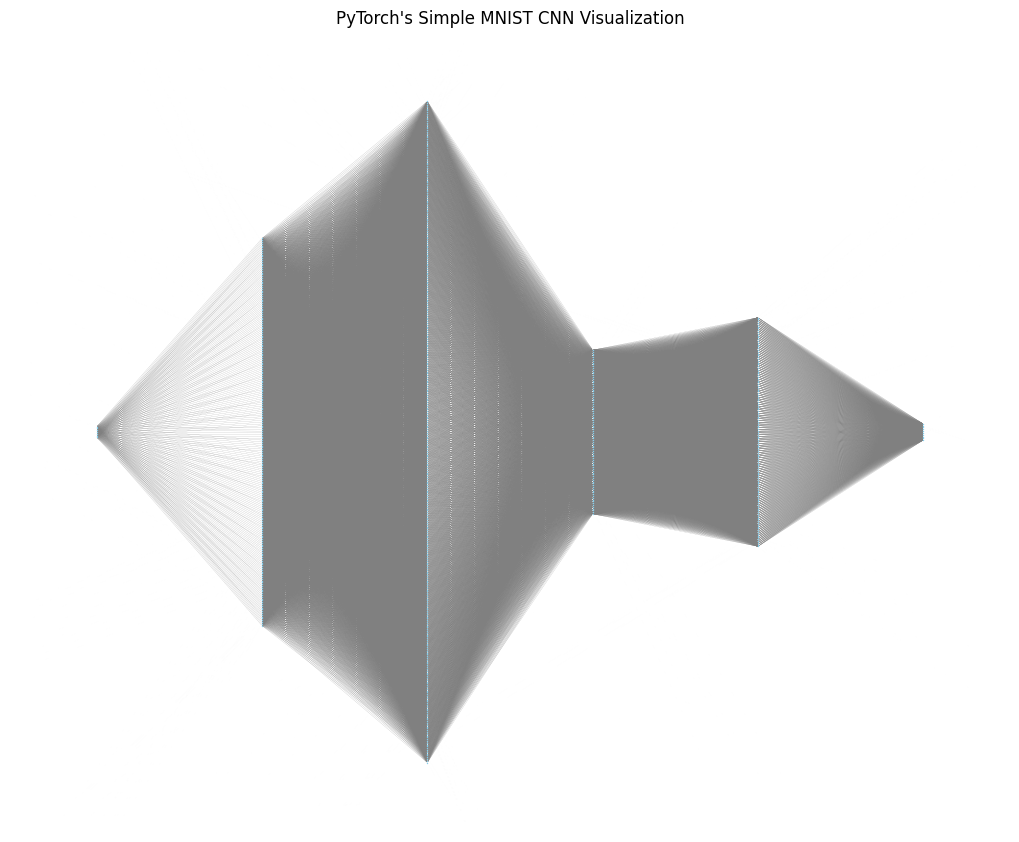

In [27]:
# Final drawing
draw_networkx_diagram(G, pos)

In [54]:
pos

{'0_0': (0, 3.5),
 '0_1': (0, 2.5),
 '0_2': (0, 1.5),
 '0_3': (0, 0.5),
 '0_4': (0, -0.5),
 '0_5': (0, -1.5),
 '0_6': (0, -2.5),
 '1_0': (1, 108.0),
 '1_1': (1, 107.0),
 '1_2': (1, 106.0),
 '1_3': (1, 105.0),
 '1_4': (1, 104.0),
 '1_5': (1, 103.0),
 '1_6': (1, 102.0),
 '1_7': (1, 101.0),
 '1_8': (1, 100.0),
 '1_9': (1, 99.0),
 '1_10': (1, 98.0),
 '1_11': (1, 97.0),
 '1_12': (1, 96.0),
 '1_13': (1, 95.0),
 '1_14': (1, 94.0),
 '1_15': (1, 93.0),
 '1_16': (1, 92.0),
 '1_17': (1, 91.0),
 '1_18': (1, 90.0),
 '1_19': (1, 89.0),
 '1_20': (1, 88.0),
 '1_21': (1, 87.0),
 '1_22': (1, 86.0),
 '1_23': (1, 85.0),
 '1_24': (1, 84.0),
 '1_25': (1, 83.0),
 '1_26': (1, 82.0),
 '1_27': (1, 81.0),
 '1_28': (1, 80.0),
 '1_29': (1, 79.0),
 '1_30': (1, 78.0),
 '1_31': (1, 77.0),
 '1_32': (1, 76.0),
 '1_33': (1, 75.0),
 '1_34': (1, 74.0),
 '1_35': (1, 73.0),
 '1_36': (1, 72.0),
 '1_37': (1, 71.0),
 '1_38': (1, 70.0),
 '1_39': (1, 69.0),
 '1_40': (1, 68.0),
 '1_41': (1, 67.0),
 '1_42': (1, 66.0),
 '1_43': (1,

In [61]:
edges = list(G.edges)
print(edges)

[('0_0', '1_0'), ('0_0', '1_7'), ('0_0', '1_14'), ('0_0', '1_21'), ('0_0', '1_28'), ('0_0', '1_35'), ('0_0', '1_42'), ('0_0', '1_49'), ('0_0', '1_56'), ('0_0', '1_63'), ('0_0', '1_70'), ('0_0', '1_77'), ('0_0', '1_84'), ('0_0', '1_91'), ('0_0', '1_98'), ('0_0', '1_105'), ('0_0', '1_112'), ('0_0', '1_119'), ('0_0', '1_126'), ('0_0', '1_133'), ('0_0', '1_140'), ('0_0', '1_147'), ('0_0', '1_154'), ('0_0', '1_161'), ('0_0', '1_168'), ('0_0', '1_175'), ('0_0', '1_182'), ('0_0', '1_189'), ('0_0', '1_196'), ('0_0', '1_203'), ('0_0', '1_210'), ('0_1', '1_1'), ('0_1', '1_8'), ('0_1', '1_15'), ('0_1', '1_22'), ('0_1', '1_29'), ('0_1', '1_36'), ('0_1', '1_43'), ('0_1', '1_50'), ('0_1', '1_57'), ('0_1', '1_64'), ('0_1', '1_71'), ('0_1', '1_78'), ('0_1', '1_85'), ('0_1', '1_92'), ('0_1', '1_99'), ('0_1', '1_106'), ('0_1', '1_113'), ('0_1', '1_120'), ('0_1', '1_127'), ('0_1', '1_134'), ('0_1', '1_141'), ('0_1', '1_148'), ('0_1', '1_155'), ('0_1', '1_162'), ('0_1', '1_169'), ('0_1', '1_176'), ('0_1',

In [30]:
node_positions = {
    0: [-0.81, -0.48, 0.38],
    1: [0.13, -0.97, 0.27],
    2: [0.91, -0.24, 0.40],
    3: [0.81, 0.48, -0.38],
    4: [-0.02, 0.20, -1.00],
    5: [-0.44, -0.70, -0.59],
    7: [-0.62, 0.55, 0.58],
    8: [0.01, -0.20, 1.00],
    9: [0.44, 0.70, 0.59],
    10: [-0.13, 0.97, -0.27],
    11: [-0.91, 0.24, -0.40],
    6: [0.63, -0.55, -0.59],
}

edges = [(0, 1), (0, 5), (0, 7), (0, 8), (0, 11), (1, 2), (1, 5), (1, 6), 
         (1, 8), (2, 3), (2, 6), (2, 8), (2, 9), (3, 4), (3, 6), (3, 9), (3, 10), 
         (4, 5), (4, 6), (4, 10), (4, 11), (5, 6), (5, 11), (7, 8), (7, 9), (7, 10), (7, 11), 
         (8, 9), (9, 10), (10, 11)]

In [56]:
for key in pos:
    x, y = pos[key]
    pos[key] = (x, y, 0.)

print(pos)

{'0_0': (0, 3.5, 0.0), '0_1': (0, 2.5, 0.0), '0_2': (0, 1.5, 0.0), '0_3': (0, 0.5, 0.0), '0_4': (0, -0.5, 0.0), '0_5': (0, -1.5, 0.0), '0_6': (0, -2.5, 0.0), '1_0': (1, 108.0, 0.0), '1_1': (1, 107.0, 0.0), '1_2': (1, 106.0, 0.0), '1_3': (1, 105.0, 0.0), '1_4': (1, 104.0, 0.0), '1_5': (1, 103.0, 0.0), '1_6': (1, 102.0, 0.0), '1_7': (1, 101.0, 0.0), '1_8': (1, 100.0, 0.0), '1_9': (1, 99.0, 0.0), '1_10': (1, 98.0, 0.0), '1_11': (1, 97.0, 0.0), '1_12': (1, 96.0, 0.0), '1_13': (1, 95.0, 0.0), '1_14': (1, 94.0, 0.0), '1_15': (1, 93.0, 0.0), '1_16': (1, 92.0, 0.0), '1_17': (1, 91.0, 0.0), '1_18': (1, 90.0, 0.0), '1_19': (1, 89.0, 0.0), '1_20': (1, 88.0, 0.0), '1_21': (1, 87.0, 0.0), '1_22': (1, 86.0, 0.0), '1_23': (1, 85.0, 0.0), '1_24': (1, 84.0, 0.0), '1_25': (1, 83.0, 0.0), '1_26': (1, 82.0, 0.0), '1_27': (1, 81.0, 0.0), '1_28': (1, 80.0, 0.0), '1_29': (1, 79.0, 0.0), '1_30': (1, 78.0, 0.0), '1_31': (1, 77.0, 0.0), '1_32': (1, 76.0, 0.0), '1_33': (1, 75.0, 0.0), '1_34': (1, 74.0, 0.0), '1_

In [34]:
import bpy
import bmesh

import sys
import os

dir = os.path.dirname(bpy.data.filepath)
if not dir in sys.path:
    sys.path.append(dir )

import positions1
import imp
imp.reload(positions1)
from positions1 import *

for node, (x, y, z) in node_positions.items():
    node_positions[node] = (x, y * 0.01, z)


# Create a new mesh and object
mesh = bpy.data.meshes.new("GraphMesh")
obj = bpy.data.objects.new("GraphObject", mesh)
bpy.context.collection.objects.link(obj)

# Create a BMesh to add vertices and edges
bm = bmesh.new()
bm_verts = {}
for key, co in node_positions.items():
    bm_verts[key] = bm.verts.new(co)

# Add edges
for edge in edges:
    v1, v2 = edge
    bm.edges.new((bm_verts[v1], bm_verts[v2]))

# Write the bmesh to the mesh
bm.to_mesh(mesh)

# Apply the Geometry Nodes modifier
modifier = obj.modifiers.new(name="GeometryNodes", type='NODES')
modifier.node_group = bpy.data.node_groups["default_node"]

modifier["Socket_2"] = 2.2
modifier["Socket_3"] = 4.4

{0: [3.5, 0, 0], 1: [2.5, 0, 0], 2: [1.5, 0, 0], 3: [0.5, 0, 0], 4: [0, 0, 0]}